In [62]:
import pandas as pd
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from sklearn.linear_model import LinearRegression
import numpy as np
from datetime import datetime
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler


## Load Data

In [59]:
# Load your OHLC data
# Load data into DataFrame
df = pd.read_csv('PPL_Daily_OHLC_2021_2025.csv', parse_dates=['date'])
df.set_index('date', inplace=True)
df.dropna
df.head()

,open,high,low,close
date,,,,
2021-01-01,90.33,90.45,97.10,90.11
2021-01-04,97.07,102.99,104.30,100.20
2021-01-05,102.21,100.00,100.60,98.26
2021-01-06,98.60,101.00,102.00,99.50
2021-01-07,99.85,101.00,101.29,97.00


## Candlesticks Display

C:\Users\khank\AppData\Local\Temp\ipykernel_33052\1679661714.py:7: FutureWarning:

'M' is deprecated and will be removed in a future version, please use 'ME' instead.



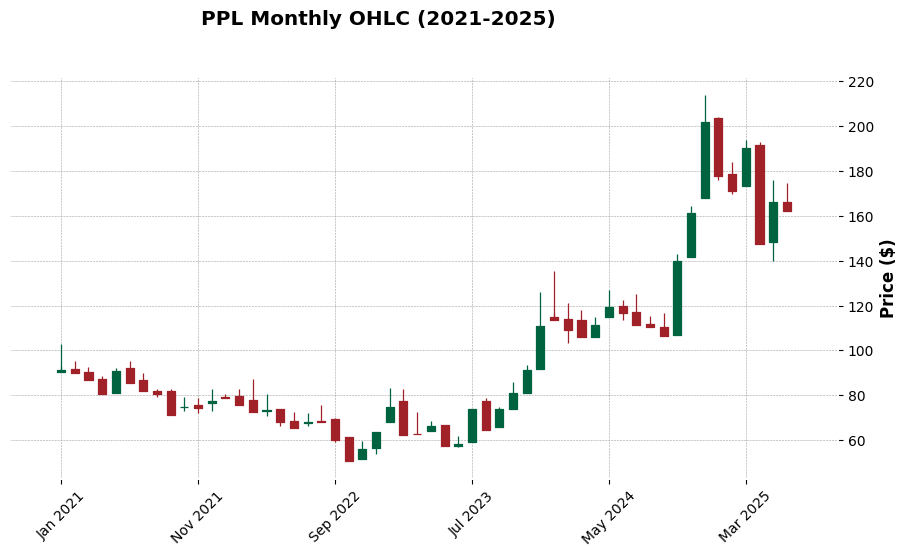

In [60]:
import pandas as pd
import mplfinance as mpf



# Resample to monthly frequency using OHLC aggregation
monthly_df = df.resample('M').agg({
    'open': 'first',
    'high': 'max',
    'low': 'min',
    'close': 'last'
})

# Remove any months with missing data
monthly_df = monthly_df.dropna()

# Plot monthly candlestick chart
mpf.plot(monthly_df,
         type='candle',
         style='charles',
         title='PPL Monthly OHLC (2021-2025)',
         ylabel='Price ($)',
         volume=False,
         figratio=(12, 6),
         datetime_format='%b %Y')  # Format x-axis as "Month Year"

## Stock Price Prediction

### LSTM


In [63]:
close_prices = df[['close']].values

# Normalize the data
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(close_prices)

# Create sequences
def create_sequences(data, seq_length):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i+seq_length])
        y.append(data[i+seq_length])
    return np.array(X), np.array(y)

SEQ_LEN = 60  # use past 60 days to predict the next one
X, y = create_sequences(scaled_data, SEQ_LEN)

# Train/Test Split
split = int(0.9 * len(X))
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

In [64]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

model = Sequential([
    LSTM(50, return_sequences=True, input_shape=(SEQ_LEN, 1)),
    Dropout(0.2),
    LSTM(50),
    Dropout(0.2),
    Dense(1)
])

model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(X_train, y_train, epochs=20, batch_size=32, validation_split=0.1)


C:\Users\khank\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



Epoch 1/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 9s 111ms/step - loss: 0.0198 - val_loss: 0.0051
Epoch 2/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 67ms/step - loss: 0.0020 - val_loss: 0.0049
Epoch 3/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 56ms/step - loss: 0.0016 - val_loss: 0.0085
Epoch 4/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 3s 107ms/step - loss: 0.0013 - val_loss: 0.0051
Epoch 5/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 4s 135ms/step - loss: 0.0011 - val_loss: 0.0048
Epoch 6/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 4s 127ms/step - loss: 0.0011 - val_loss: 0.0038
Epoch 7/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 3s 114ms/step - loss: 0.0013 - val_loss: 0.0049
Epoch 8/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 4s 131ms/step - loss: 0.0012 - val_loss: 0.0046
Epoch 9/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 64ms/step - loss: 0.0011 - val_loss: 0.0030
Epoch 10/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 79ms/step - loss: 0.0010 - val_loss: 0.0029
Epoch 11/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 68ms/step - loss: 0.0010 - val_loss: 0.0049
Epoch 12/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 74ms/step - los

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 420ms/step


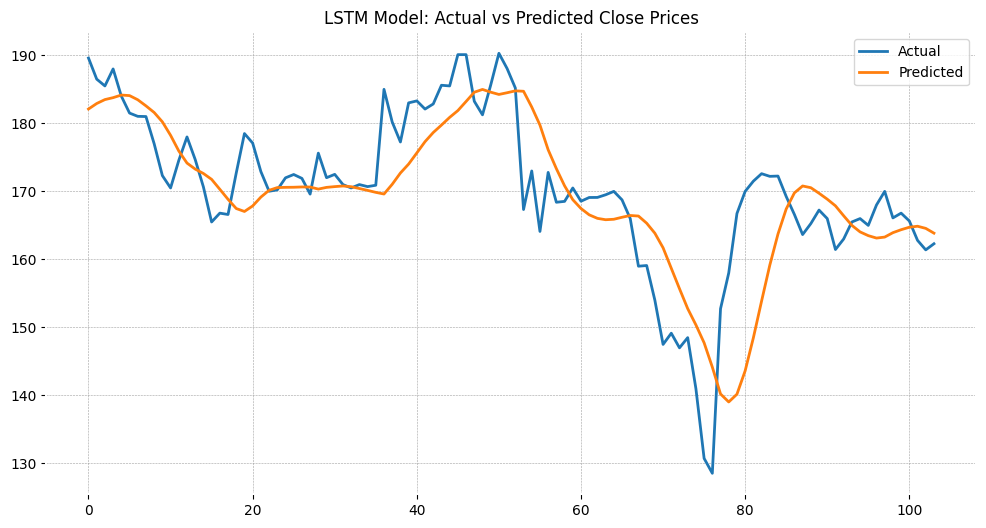

In [65]:
y_pred = model.predict(X_test)
y_pred = scaler.inverse_transform(y_pred)
y_test_unscaled = scaler.inverse_transform(y_test)

# Plot actual vs predicted
import matplotlib.pyplot as plt

plt.figure(figsize=(12,6))
plt.plot(y_test_unscaled, label='Actual')
plt.plot(y_pred, label='Predicted')
plt.legend()
plt.title('LSTM Model: Actual vs Predicted Close Prices')
plt.show()


In [66]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

rmse = np.sqrt(mean_squared_error(y_test_unscaled, y_pred))
mae = mean_absolute_error(y_test_unscaled, y_pred)

print(f"RMSE: {rmse:.2f}, MAE: {mae:.2f}")


RMSE: 7.98, MAE: 5.68


### Predict future dates:
</br>📅 1st September 2025
</br>📅 1st December 2025
</br>📅 1st June 2026

In [67]:
last_60_days = scaled_data[-60:]  # shape (60, 1)

In [68]:
input_sequence = last_60_days.reshape(1, 60, 1)


In [69]:
from datetime import datetime, timedelta
import pandas as pd

# Assuming your dataset ends at June 21, 2025
last_known_date = datetime.strptime("2025-06-21", "%Y-%m-%d")

# Target future dates
future_dates = [
    datetime(2025, 9, 1),
    datetime(2025, 12, 1),
    datetime(2026, 6, 1)
]

# Generate business days only (skip weekends)
business_days = pd.date_range(start=last_known_date + timedelta(days=1), end=future_dates[-1], freq='B')

# Total days to predict
days_to_predict = len(business_days)
print(f"Need to predict {days_to_predict} business days")


Need to predict 246 business days


In [70]:
future_predictions = []

for _ in range(days_to_predict):
    next_pred = model.predict(input_sequence)[0][0]
    future_predictions.append(next_pred)

    # Append and slide window
    input_sequence = np.append(input_sequence[:, 1:, :], [[[next_pred]]], axis=1)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━

In [72]:
predicted_prices = scaler.inverse_transform(np.array(future_predictions).reshape(-1, 1))


In [73]:
target_predictions = {}
for target in future_dates:
    index = business_days.get_loc(target)
    target_predictions[target.strftime('%Y-%m-%d')] = predicted_prices[index][0]


In [74]:
for date, price in target_predictions.items():
    print(f"Predicted Close on {date}: PKR {price:.2f}")


Predicted Close on 2025-09-01: PKR 146.38
Predicted Close on 2025-12-01: PKR 134.11
Predicted Close on 2026-06-01: PKR 121.52


In [79]:
# Format: {'date': predicted_price}
target_predictions = {
    '2025-09-01': 146.38,
    '2025-12-01': 134.11,
    '2026-06-01': 121.52
}


## Investment Projection (10000 PKR on 1st June 2025)

In [85]:
# Predict 2025-06-01 (business day index 0)
buy_price = predicted_prices[0][0]
shares_bought = 10000 / buy_price


In [86]:
for date, price in target_predictions.items():
    value = shares_bought * price
    profit = value - 10000
    print(f"Value on {date}: PKR {value:.2f} | Profit: PKR {profit:.2f}")


Value on 2025-09-01: PKR 8974.63 | Profit: PKR -1025.37
Value on 2025-12-01: PKR 8222.35 | Profit: PKR -1777.65
Value on 2026-06-01: PKR 7450.45 | Profit: PKR -2549.55
